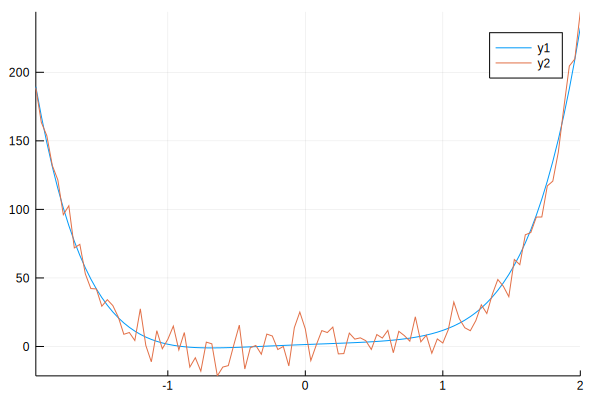

In [6]:
using Plots
#Choose how many the degree of the polynomial you want to use
k = 7
#Choose the means and standard deviations of the distributions of the parameters
mean = [1 3 1 2 4 -1 3]
std = [1 1 1 1 1 1 1]
#Generates the parameter values by sampling them from Guassian with the chosen means and standard deviaitons
truep = randn(k).*std' + mean'
#Sets the range of the x values of the data set
min = -2
max = 2
#Choose the number of data points
samples = 100
#Choose the standard deviation of the noise
noise = 10
#Generates evenly spaced X values inbetween the min and max values 
X = [(1 - i/samples)*min + i/samples*max for i in 1:samples]
#Generates the true Y values as a k - 1 order polynomial using the truep values as the coeffiecients
Ytrue = [sum(truep[j]*x^(j - 1) for j in 1:k) for x in X]
#Generates the data's Y values added noise to the true Y values 
#by randomly sampling from a Gaussian with a standard deviation of 'noise'
Ydata = Ytrue + randn(samples)*noise

mintest = -1
maxtest = 1
Xtest = [(1 - i/samples)*mintest + i/samples*maxtest for i in 1:samples]
Ytest = [sum(truep[j]*x^(j - 1) for j in 1:k) for x in Xtest]
Ytestdata =  Ytest + randn(samples)*noise
plot(X, Ytrue)
plot!(X, Ydata)

In [3]:
using JuMP, Mosek
CVS = 0 #cross validation score
for v = 1:length(X)        
    CVX = zeros(length(X) - 1)
    CVY = zeros(length(Ydata) - 1)
    b = 0
    for i = 1:samples
        if i != v
            b = b + 1
            CVX[b] = X[i]
            CVY[b] = Ydata[i]
        end
    end
    TestX = zeros(k)
    for j = 1:k
        TestX[j] = X[v]^(k-j)
    end
    A = zeros(length(CVX),k)
    for i = 1:length(CVX)
        for j = 1:k
            A[i,j] = CVX[i]^(k-j)
        end
    end
    m = Model(solver = MosekSolver(LOG=0))
    @variable(m, p[1:k])
    @expression(m, LS, sum((CVY - A*p).^2))
    @objective(m, Min, LS)
    solve(m)
    CVS = CVS + (Ydata[v] - sum(TestX[i]*getvalue(p)[i] for i = 1:k))^2
end
println(CVS)

10865.530413240385


In [4]:
using JuMP, Ipopt, Mosek
CVS = 0 #cross validation score
for v = 1:length(X)        
    CVX = zeros(length(X) - 1)
    CVY = zeros(length(Ydata) - 1)
    b = 0
    for i = 1:samples
        if i != v
            b = b + 1
            CVX[b] = X[i]
            CVY[b] = Ydata[i]
        end
    end
    TestX = zeros(k)
    for j = 1:k
        TestX[j] = X[v]^(k-j)
    end
    A = zeros(length(CVX),k)
    for i = 1:length(CVX)
        for j = 1:k
            A[i,j] = CVX[i]^(k-j)
        end
    end
    #=b = Model(solver = IpoptSolver(print_level=0))
    @variable(b, h[1:k])
    @variable(b, o >= 0)
    #@expression(b, )
    @NLobjective(b, Max, -samples/2*log(2*pi*o^2) - sum((CVY[i] - sum(A[i,j]*h[j] for j = 1:k))^2 for i = 1:length(CVX))/(2*o^2) + sum(-.5(h[i] - mean[i])^2/std[i]^2 for i = 1:k))
    solve(b)=#
    b = Model(solver = IpoptSolver(print_level=0))
    @variable(b, p[1:k])
    @variable(b, o >= 0) #The standard deviation of the error
    @NLexpression(b, LeastSquares, sum((CVY[i] - sum(A[i,j]*p[j] for j = 1:k))^2 for i = 1:length(CVX)))
    @NLexpression(b, Likelihood, -samples/2*log(2*pi*o^2) - LeastSquares/(2*o^2))
    @NLexpression(b, Prior, -sum(.5(p[i] - mean[i])^2/std[i]^2 for i = 1:k))
    @NLobjective(b, Max, Likelihood + Prior)
    CVS = CVS + (Ydata[v] - sum(TestX[i]*getvalue(p)[i] for i = 1:k))^2
end
println(CVS)

NaN


In [29]:
using JuMP, Ipopt
A = zeros(length(X),k)
for i = 1:length(X)
    for j = 1:k
        A[i,j] = X[i]^(k-j)
    end
end
m = Model(solver = IpoptSolver(LOG=0))
@variable(m, p[1:k])
@NLexpression(m, LS, sum((Ydata - A*p).^2))
@NLexpression(m, loglikelihood, -samples/2*log(2*pi*noise^2) - LS/(2*noise^2))
@NLexpression(m, Prior, -sum(.5(p[i] - mean[i])^2/std[i]^2 for i = 1:k))
@NLobjective(m, Max, loglikelihood + Prior)
solve(m)

LoadError: [91mUnrecognized function "sum" used in nonlinear expression.[39m

In [8]:
using JuMP, Ipopt
A = zeros(length(X),k)
for i = 1:length(X)
    for j = 1:k
        A[i,j] = X[i]^(k-j)
    end
end
n = Model(solver = IpoptSolver(print_level=0))
@variable(n, q[1:k])
@objective(n, Min, sum((Ydata - A*q).^2))
solve(n)

b = Model(solver = IpoptSolver(print_level=0))
@variable(b, h[1:k])
@variable(b, o >= 0)
@NLexpression(b, Likelihood, -samples/2*log(2*pi*o^2) - sum((Ydata[i] - sum(A[i,j]*h[j] for j = 1:k))^2 for i = 1:length(X))/(2*o^2))
@NLexpression(b, Prior, -sum(.5(h[i] - mean[i])^2/std[i]^2 for i = 1:k))
@NLobjective(b, Max, Likelihood + Prior)
solve(b)
println(getvalue(q))
println(getvalue(h))
println(truep)
LSscore = 0
Pscore = 0
Atest = zeros(length(Xtest),k)
for i = 1:length(Xtest)
    for j = 1:k
        A[i,j] = Xtest[i]^(k-j)
    end
end
for j = 1:length(Xtest)
    LSscore = LSscore + (Ytestdata[j] - sum(Atest[j,i]*getvalue(q)[i] for i = 1:k))^2
    Pscore = Pscore + (Ytestdata[j] - sum(Atest[j,i]*getvalue(h)[i] for i = 1:k))^2
end
println("Least Squares Score: ",LSscore)
println("Maximum Posterior Score: ", Pscore)

[2.50966, 1.11001, 5.41914, -5.22449, -6.13479, 10.1554, 3.05888]
[3.24274, -0.0770275, 0.314214, 1.93789, 2.78491, 0.270985, 1.83267]
[1.4127; 3.83556; -0.892074; 1.54172; 3.53811; -0.319515; 2.63094]
Least Squares Score: 10043.405906657204
Maximum Posterior Score: 10043.405906657204


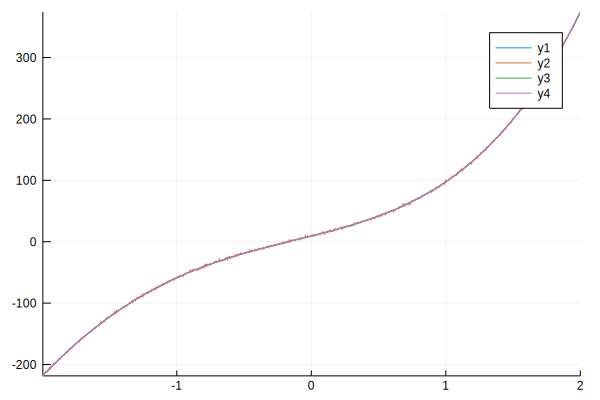

In [91]:
z = Array{Float64}(length(X))
w = Array{Float64}(length(X))
for i = 1:length(X)
    z[i] = sum(getvalue(p)[j]*X[i]^(k-j) for j = 1:k)
    w[i] = sum(getvalue(q)[j]*X[i]^(k-j) for j = 1:k)
end
plot(X, Ytrue)
plot!(X, Ydata)
plot!(X, z)
plot!(X, w)

In [86]:
using JuMP, Ipopt
A = zeros(length(X),k)
for i = 1:length(X)
    for j = 1:k
        A[i,j] = X[i]^(k-j)
    end
end
b = Model(solver = IpoptSolver(print_level=0))
@variable(b, h[1:k])
@variable(b, o >= 0)
#@expression(m, loglikelihood, -samples/2*log(2*pi*noise^2) - LS/(2*noise^2))
@NLobjective(b, Max, -samples/2*log(2*pi*o^2) - sum((Ydata[i] - sum(A[i,j]*h[j] for j = 1:k))^2 for i = 1:length(X))/(2*o^2) + sum(-.5(h[i] - mean[i])^2/std[i]^2 for i = 1:k))
solve(b)
println(getvalue(h))
println(getvalue(o))

[3.24487, 21.067, 24.1491, 47.0635, 11.6331]
10.137001574535285


In [ ]:
m = Model(solver = IpoptSolver(print_level=0))
@variable(m, p[1:k])
#@expression(m, loglikelihood, -samples/2*log(2*pi*noise^2) - LS/(2*noise^2))
@objective(m, Max, -sum((Ydata - A*p).^2)/(2*noise^2) - sum(.5(p[i] - mean[i])^2/std[i]^2 for i = 1:k))
solve(m)